In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt 

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2 

In [5]:
%matplotlib inline

In [6]:
import pathlib

In [7]:
CWD = pathlib.Path.cwd()

In [8]:
import sys

In [9]:
import time

In [10]:
sys.path.append('../../ml4seas/')

In [11]:
import numpy as np 
import pandas as pd 
import xarray as xr

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
from NN import *

### some parameters for the model and the logs 

In [15]:
if len(tf.config.list_physical_devices('GPU')) >= 1: 
    compute = 'GPU'
else: 
    compute = 'CPU'

In [72]:
print(f"using the {compute}")

using the GPU


In [16]:
batch_size=32

In [17]:
padd = 8

In [18]:
input_shape = (180, 360, 1) # last for the number of channels 

In [19]:
resize_shape = (176, 360) # to be evenly divided by the padd

In [20]:
n_epochs = 20 # number of epochs 

### list the files 

In [21]:
dpath = pathlib.Path('../../../data/GCMs/processed/hindcasts/CDS/CMCC/T2M/')

In [22]:
lfiles = list(dpath.glob("CMCC_T2M_seasonal_anomalies_????_??.nc"))

In [23]:
lfiles.sort()

In [24]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested', parallel=True)

In [25]:
dset

,Array,Chunk
Bytes,8.96 GB,31.10 MB
Shape,"(288, 40, 3, 180, 360)","(1, 40, 3, 180, 360)"
Count,1152 Tasks,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,6.91 kB,24 B
Shape,"(288, 3)","(1, 3)"
Count,1152 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray


### selects the training set 

In [26]:
dset_train = dset.sel(time=slice('1993','2010'))

In [27]:
dset_val = dset.sel(time=slice('2011',None))

### select one step (leadtime = 3 months), and only t2m 

In [28]:
dset_train = dset_train[['t2m']].sel(step=3)

In [29]:
dset_val = dset_val[['t2m']].sel(step=3)

### concatenate all the members long the first dimension, to increase number of instances 

In [30]:
dset_train = dset_train.stack(instance=('time','member'))

In [31]:
dset_val = dset_val.stack(instance=('time','member'))

### get the repeated datetimes (will be useful to sample repeatedly in Yds)

In [32]:
rdatetimes_train = dset_train.indexes["instance"].get_level_values(0)

In [33]:
rdatetimes_val = dset_val.indexes["instance"].get_level_values(0)

### transpose to have the instances as the first dimension 

In [34]:
dset_train = dset_train.transpose('instance','lat','lon')

In [35]:
dset_val = dset_val.transpose('instance','lat','lon')

### Generate data for tensorflow 

In [36]:
data_train = XrDataGenerator(dset_train, dset_train, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=None, std=None, shuffle=True, load=False)

In [37]:
data_val = XrDataGenerator(dset_val, dset_val, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=data_train.mean, std=data_train.std, shuffle=True, load=False)

### checks the shape (should be (batch_size, (input_shape), channels)) 

In [38]:
data_train[0][0].shape

(32, 180, 360, 1)

In [39]:
data_val[0][0].shape

(32, 180, 360, 1)

### build the model 

#### encoder 

In [40]:
# Input placeholder
original = Input(shape=(180,360,1))

# Resize to have dimensions divisible by 8
resized = ResizeLayer(newsize=(176,360))(original)

# # Wrap-around in longitude for periodic boundary conditions

padded = PeriodicPadding2D(padd)(resized)

# Encoding layers
x = Conv2D(16, (3, 3), padding='same')(padded)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)

In [41]:
encoded = MaxPooling2D((2, 2), padding='same')(x)

#### decoder 

In [42]:
# Decoding layers
x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same')(x)

# Strip the longitude wrap-around
pruned = PrunePeriodicPadding2D(padd)(decoded)

In [43]:
outsize = ResizeLayer(newsize=(180,360))(pruned)

In [44]:
autoencoder = Model(original,outsize)

In [45]:
autoencoder.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 180, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 176, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 192, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)  

### build the callbacks 

In [46]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")

### checkpoint 

In [47]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(f"./autoencoder_checkpoint_{run_id}_{compute}.h5", save_best_only=True)

### early stopping 

In [48]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [49]:
import os

In [50]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [51]:
def get_run_logdir(run_id):
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir(run_id)
run_logdir

'./my_logs/run_2020_08_05-13_30_47'

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### compile 

In [54]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
autoencoder.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 180, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 176, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 192, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)  

### fit 

### Note: run tensorboard with: 
        
```
tensorboard --logdir=./my_logs  --port=6006
```
<hr>

In [56]:
# autoencoder.fit_generator(generator=data_train,
#                     validation_data=data_val,
#                     use_multiprocessing=True,
#                     workers=6,epochs=n_epochs, 
#                     callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [57]:
history = autoencoder.fit(data_train, validation_data=data_val, epochs=n_epochs, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
270/270 [==============================] - 165s 612ms/step - loss: 0.2813 - val_loss: 0.0983
Epoch 2/20
270/270 [==============================] - 168s 622ms/step - loss: 0.0950 - val_loss: 0.0715
Epoch 3/20
270/270 [==============================] - 177s 656ms/step - loss: 0.0758 - val_loss: 0.0617
Epoch 4/20
270/270 [==============================] - 175s 649ms/step - loss: 0.0669 - val_loss: 0.0562
Epoch 5/20
270/270 [==============================] - 164s 606ms/step - loss: 0.0613 - val_loss: 0.0521
Epoch 6/20
270/270 [==============================] - 160s 593ms/step - loss: 0.0573 - val_loss: 0.0490
Epoch 7/20
270/270 [==============================] - 164s 607ms/step - loss: 0.0540 - val_loss: 0.0465
Epoch 8/20
270/270 [==============================] - 168s 622ms/step - loss: 0.0515 - val_loss: 0.0445
Epoch 9/20
270/270 [==============================] - 163s 606ms/step - loss: 0.0495 - val_loss: 0.0436
Epoch 10/20
270/270 [==============================] - 165s 613m

### save model 

In [58]:
saved_model = CWD / f"saved_autoencoder_{run_id}_{n_epochs}_epochs_{compute}" 

In [59]:
keras.models.save_model(autoencoder, saved_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/nicolasf/research/Smart_Ideas/code/models/CNN/saved_autoencoder_run_2020_08_05-13_30_47_20_epochs_GPU/assets


### save history file 

In [60]:
import pickle

In [61]:
saved_history = CWD / f"saved_history_{run_id}_{n_epochs}_epochs_{compute}.pkl" 

In [62]:
pickle.dump(autoencoder.history.history, open(saved_history, "wb"))

### Some plots 

### validation data first batch 

In [63]:
data_val[0][0].shape

(32, 180, 360, 1)

### take one from the batch 

In [113]:
i = 10

In [114]:
X = data_val[0][0][i:i+1,:,:,:]

In [115]:
X.shape

(1, 180, 360, 1)

In [116]:
pred = autoencoder.predict(X)

In [117]:
pred.shape

(1, 180, 360, 1)

In [118]:
pred = pred.squeeze()

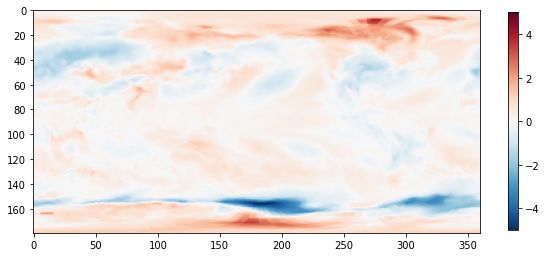

In [119]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data_val[0][0][i,::-1,:,0], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.colorbar(im, shrink=0.4)

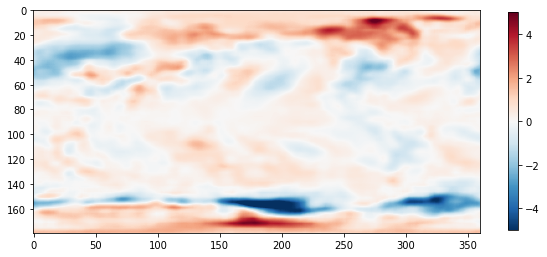

In [120]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(pred[::-1,:], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)  
plt.colorbar(im, shrink=0.4)

### Plots the training and validation loss 

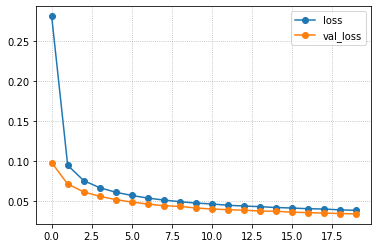

In [141]:
f, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax=ax, marker='o')
ax.grid(ls=':')

In [142]:
pd.DataFrame(history.history)

,loss,val_loss
0,0.281269,0.098274
1,0.095011,0.071510
2,0.075827,0.061749
3,0.066949,0.056168
4,0.061277,0.052149
5,0.057265,0.048958
6,0.053997,0.046535
7,0.051508,0.044454
8,0.049537,0.043631
9,0.047748,0.041579


### load a previously saved model (20 epochs, but with adadelta optim) 

In [153]:
with open('./saved_history_run_2020_08_05-12_23_37_20_epochs.pkl', 'rb') as f: 
    history = pickle.load(f)

In [155]:
pd.DataFrame(history)

,loss,val_loss
0,2.184552,1.664793
1,2.153686,1.632631
2,2.105614,1.566928
3,1.823752,1.207865
4,1.136532,0.859549
5,0.770167,0.517464
6,0.549028,0.409080
7,0.490587,0.377374
8,0.456456,0.351919
9,0.427613,0.329715


In [156]:
run_id

'run_2020_08_05-13_30_47'

In [159]:
data_train.mean.data[0]

-0.06464051

In [160]:
data_train.std.data[0]

1.4709691

In [161]:
autoencoder.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 180, 360, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'ResizeLayer',
   'config': {'newsize': (176, 360)},
   'name': 'resize_layer',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'PeriodicPadding2D',
   'config': {'name': 'periodic_padding2d',
    'trainable': True,
    'dtype': 'float32',
    'pad_width': 8},
   'name': 'periodic_padding2d',
   'inbound_nodes': [[['resize_layer', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUnifor